# Зависимость рождаемости от брачности на основе анализа временных рядов

## 1) Визуальный анализ


### 1.1 Подготовка данных по брачности

##### Импорт необходимых для дальнейшей работы библиотек

In [1]:
import pandas as pd # библиотека для работы с табличными данными
import matplotlib.pyplot as plt # библиотека для построения графиков
import matplotlib.ticker as ticker # модуль управления тиками
from statsmodels.graphics.tsaplots import plot_acf # АКФ
import statsmodels.api as sm # библиотека статистических функций 

##### Загрузка данных из csv-файла в датафрейм pandas

In [8]:
df_marriage = pd.read_csv('divorce_marriage.csv', encoding='ansi')

##### Отображение структуры полученного датафрейма

In [9]:
df_marriage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28878 entries, 0 to 28877
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   territory               28878 non-null  int64  
 1   id_indicator            28878 non-null  int64  
 2   period                  28878 non-null  object 
 3   territory.ccube.0       28878 non-null  object 
 4   territory.ccube.1       28568 non-null  object 
 5   territory.ccube.2       26112 non-null  object 
 6   territory.ccube.attr.0  28878 non-null  int64  
 7   territory.ccube.3       28878 non-null  object 
 8   territory.ccube.4       28878 non-null  object 
 9   value                   28878 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.2+ MB


    - id_indicator - это id показателя (браки = 814, разводы = 816)
    - territory.ccube.(0-2) - это идентификатор уровня субъекта (0 - страна, 1 - федеральный округ, 2 - область или округ)
*В связи с этим составим датафрейм, выбрав только нужный нам субъект и показатель*

In [5]:
orel_df = df.loc[(df['territory.ccube.3'] == 'Орловская область') & (df['id_indicator'] == 814)]

Отображение нового датафрейма по бракам для Орловской области после удаления лишних колонок

In [6]:
new_df = orel_df.drop(["territory", "id_indicator", "territory.ccube.0", "territory.ccube.1", "territory.ccube.2", "territory.ccube.attr.0", "territory.ccube.3", "territory.ccube.4"], axis=1)

In [7]:
new_df.dropna()

,period,value
1584,31 Jan 2009 00:00:00,5.16
1585,28 Feb 2009 00:00:00,6.84
1586,31 Mar 2009 00:00:00,5.61
1587,30 Apr 2009 00:00:00,6.20
1588,31 May 2009 00:00:00,5.58
...,...,...
27950,31 Aug 2021 00:00:00,6.30
28138,30 Sep 2021 00:00:00,6.60
28326,31 Oct 2021 00:00:00,6.50
28514,30 Nov 2021 00:00:00,6.30


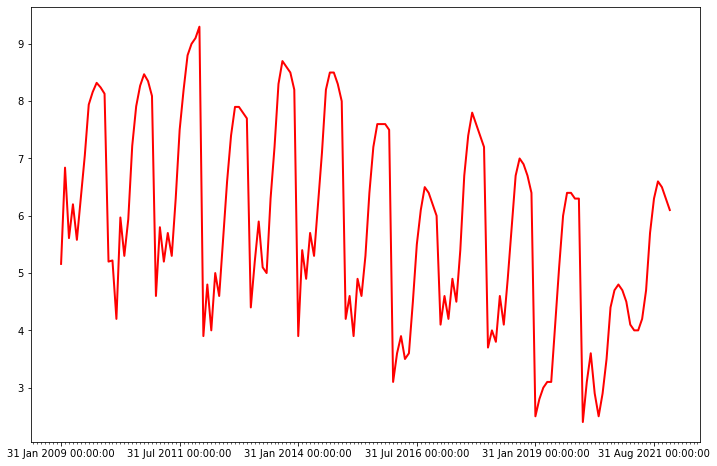

In [8]:
fig, ax = plt.subplots()

x = new_df['period']
y = new_df['value']

ax.plot(x, y, color = 'r', linewidth = 2)

#  Исправление формата подписей оси x
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))


fig.set_figwidth(12)
fig.set_figheight(8)

plt.show()

## 2) Тест Дикки-Фуллера

### Этот этап необходим для того, чтобы подтвердить гипотезу о нестационарности имеющегося ряда

In [11]:
import statsmodels.api as sm

In [12]:
test = sm.tsa.stattools.adfuller(orel_df['value'])
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('ряд не стационарен')
else:
    print('ряд стационарен')

adf:  -1.6855543395519295
p-value:  0.4385702627984426
Critical values:  {'1%': -3.477261624048995, '5%': -2.8821181874544233, '10%': -2.5777431104939494}
ряд не стационарен


## 3) Приведение ряда к стационарному виду

### Этот этап необходим для того, чтобы получить параметр d - порядок дифференцирования, который позволяет перейти от нестационарного ряда к стационарному

In [15]:
stat_df = pd.DataFrame()

In [16]:
stat_df['value'] = new_df['value'].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period.

In [18]:
stat_df

,value
1585,1.68
1586,-1.23
1587,0.59
1588,-0.62
1589,0.73
...,...
27950,0.60
28138,0.30
28326,-0.10
28514,-0.20


In [28]:
stat_df2 = stat_df2[pd.notnull(stat_df2['value'])]

Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод notnull().

In [19]:
test = sm.tsa.stattools.adfuller(stat_df['value'])
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('ряд не стационарен')
else:
    print('ряд стационарен')

adf:  -3.9300152040897545
p-value:  0.0018247266254211715
Critical values:  {'1%': -3.477261624048995, '5%': -2.8821181874544233, '10%': -2.5777431104939494}
ряд стационарен


#### Получили, что дифференцирование первого порядка (d=1) позволяет привести ряд к стационарному виду

## 4) Построение модели временного ряда

### 4.1) Построение графика АКФ и ЧАКФ для нахождения q - параметра скользящего среднего и p - порядка афторегрессии

https://studme.org/41017/ekonomika/opredelenie_poryadka_modeli_avtoregressii_skolzyaschey_sredney

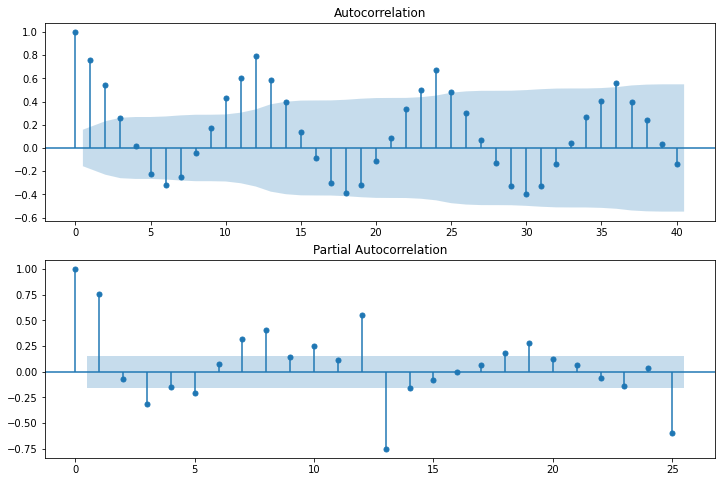

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_df['value'].values.squeeze(), lags=40, ax=ax1)

### 5.2) Построение модели SARIMA

#### 5.2.1) Формирование набора данных, которые используем для построения модели и статистического тестирования

In [23]:
data_model = new_df['value'].dropna()

In [24]:
data_model = data_model.reset_index(drop=True)

In [25]:
data_model_test = data_model.iloc[:140]

In [26]:
data_model_test

0      5.16
1      6.84
2      5.61
3      6.20
4      5.58
       ... 
135    2.90
136    2.50
137    2.90
138    3.50
139    4.40
Name: value, Length: 140, dtype: float64

#### 5.2.2) Задаём параметры модели SARIMA(p,d,q)(P,D,Q)m

    p: Порядок авторегрессии тренда.
    d: Порядок изменения тренда.
    q: Тренд скользящей средней.
    
    P: Сезонный порядок авторегрессии.
    D: Порядок сезонных разниц.
    Q: Сезонный порядок скользящих средних.
    m: Количество временных шагов за один сезонный период.

https://machinelearningmastery.ru/sarima-for-time-series-forecasting-in-python/

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [37]:
my_order = (3,1,1) # (p,d,q)

In [46]:
my_seasonal_order = (1,1,2,12) # (P,D,Q,m)

In [47]:
model = sm.tsa.SARIMAX(data_model_test, order=my_order, seasonal_order=my_seasonal_order).fit(full_output=False, disp=0)

In [48]:
pred = model.predict(140,165, typ='levels')

<AxesSubplot:>

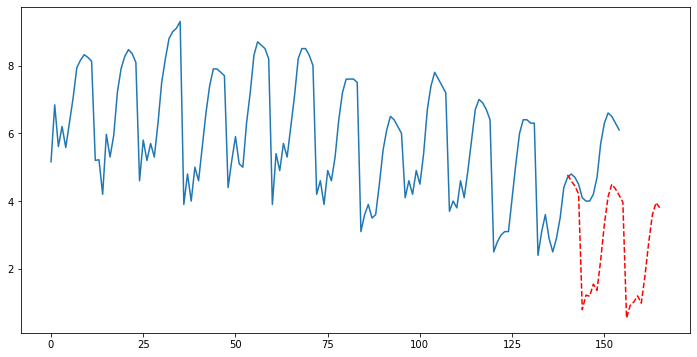

In [49]:
data_model.plot(figsize=(12,6))
pred.plot(style='r--')